---
**License**

 NC_ccl_xcor_dndz_interpolation_methods

 Thu Feb 29 12:00:00 2024\
 Copyright  2024\
 Luigi Lucas de Carvalho Silva <luigi.lcsilva@gmail.com>

---
---

 NC_ccl_xcor_dndz_interpolation_methods\
 Copyright (C) 2024 Luigi Lucas de Carvalho Silva <luigi.lcsilva@gmail.com>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Startups and Packages

First of all, let us import some useful packages.

In [1]:
######## NUM COSMO ########
try:
    import gi

    gi.require_version("NumCosmo", "1.0")
    gi.require_version("NumCosmoMath", "1.0")
except:
    pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

######## CCL ########
import pyccl as pyccl

######## GENERAL ########
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

######## COMPARISSON ########
sys.path.append('/home/luigi/cosmology/NumCosmo/numcosmo_py/ccl/')

from nc_ccl import create_nc_obj
from nc_ccl import CCLParams

ccl_params_class = CCLParams()
ccl_cosmo_set_high_prec = ccl_params_class.set_high_prec_params

#create_nc_obj: Create a NumCosmo object from a CCL cosmology.
#ccl_cosmo_set_high_prec: Set CCL cosmology to high precision.

Now, let us get the libraries versions.

In [2]:
### GETTING NUMCOSMO VERSION
#dir(Ncm) # Show the library functions.

ncmpath = Ncm.__path__[0]
ncmpath = ncmpath.replace("/NumCosmoMath-1.0.typelib","")
buildfile = open(ncmpath+"/build_cfg.h", "r").readlines()

for line in buildfile:
    if "NUMCOSMO_VERSION" in line:
        ncversion=line
        for ch in ['#define','NUMCOSMO_VERSION','"','\n','  ']:
            if ch in ncversion:
                ncversion = ncversion.replace(ch,'')
print('NumCosmo Version: '+ncversion)
                
### GETTING CCL VERSION
print("CCL Version: "+str(pyccl.__version__))

NumCosmo Version: 0.21.2
CCL Version: 3.0.1.dev102+g892655a7


Now, let us initialize the NumCosmo library.

In [3]:
Ncm.cfg_init ()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Cosmological parameters

In [4]:
# Fixed parameters.
Neff_massless_neutrinos = 3.0       # Effective number of massless neutrinos present. For the massive case, the Neff is
                                    # defined with the other parameters in the cosmology array.   
T_CMB = 2.726                       # The CMB temperature today. 

######### COSMOLOGIES ##########
#Reference: https://arxiv.org/pdf/1812.05995.pdf, Table 3 and Table 4.
#Order of parameters: Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu
CCL_cosmologies = {}
### MASSLESS NEUTRINOS ####
CCL_cosmologies["CCL1"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, Neff_massless_neutrinos, 0]  #flat ΛCDM
CCL_cosmologies["CCL2"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -0.9, 0.0, Neff_massless_neutrinos, 0]  #wCDM
CCL_cosmologies["CCL3"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0 ]  #wCDM
#CCL_cosmologies["CCL4"] = [0.25, 0.05, 0.65, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0] #open wCDM    # Bad results for k different from 0.
#CCL_cosmologies["CCL5"] = [0.25, 0.05, 0.75, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0] #closed wCDM  # Bad results for k different from 0.
#CCL_cosmologies["CCL6"] = [0.3, 0.0, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, Neff_massless_neutrinos, 0]    #flat ΛCDM    # Kernel dying for this cosmology
CCL_cosmologies["WMAP7"] = [0.2265, 0.0455, 0.728, 0.704, 0.810, 0.967, -1.0, 0.0, Neff_massless_neutrinos, 0] #flat ΛCDM
CCL_cosmologies["Planck2013"] = [0.269, 0.0490, 0.682, 0.671, 0.834, 0.962, -1.0, 0.0, Neff_massless_neutrinos, 0] #flat ΛCDM
### MASSIVE NEUTRINOS ####
# Obs.: The create_nc_obj from nc_ccl.py is not updated for the new version of CCL. So, we cannot include massive neutrinos right now.
#CCL_cosmologies["CCL7"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, 3.013, [0.04,0,0]]  #flat ΛCDM, mν

cosmo_names = []
for key, value in CCL_cosmologies.items():
    cosmo_names.append(key)

# Defining the tracers

In [5]:
###################### TIME START ##########################
start = time.time()

######## REDSHIFT DISTRIBUTION OF OBJECTS FROM HISTOGRAM ########
### Getting the redshift distribution for the objects from the CCL bin1_histo and bin2_histo files.
# Source: https://github.com/LSSTDESC/CCL/tree/master/benchmarks/data -- Files bin1_histo.txt and bin2_histo.txt
# Used in the CCL article: https://arxiv.org/pdf/1812.05995.pdf

# Loading the data. The txt files have 2 columns. The first column contains the redshift values, 
# and the second column contains the dndz values.
bin1_histo = np.loadtxt("./data/bin1_histo.txt", delimiter=" ") # Loading the first histogram.
len_bin1_histo = bin1_histo.shape[0] # Getting the number of lines.

bin2_histo = np.loadtxt("./data/bin2_histo.txt", delimiter=" ") # Loading the second histogram.
len_bin2_histo = bin2_histo.shape[0] # Getting the number of lines.

# Saving the redshift in two lists.
z_bin1_histo = []
z_bin2_histo = []

for i in range(len_bin1_histo):
    z_bin1_histo.append(bin1_histo[i][0])

for i in range(len_bin2_histo):
    z_bin2_histo.append(bin2_histo[i][0])

z_bin1_histo_np = np.array(z_bin1_histo)
z_bin2_histo_np = np.array(z_bin2_histo)

# Checking if the histograms have the same number of lines, and if the redshifts values are equal.
if len_bin1_histo != len_bin2_histo:
    print("Different histograms size!")
else:
    print("Equal histograms size! \n")
    z_histo_diff = [z_bin1_histo[i] - z_bin2_histo[i] for i in range(len_bin1_histo)]
    count_z_histo_diff_nonzero = np.count_nonzero(z_histo_diff)
    if count_z_histo_diff_nonzero == 0:
        print("Redshifts are also equal!")

# Saving the dndz values in two lists.
dndz_bin1_histo = []
dndz_bin2_histo = []
for i in range(len_bin1_histo):
    dndz_bin1_histo.append(bin1_histo[i][1])

for i in range(len_bin2_histo):
    dndz_bin2_histo.append(bin2_histo[i][1])

dndz_bin1_histo_np = np.array(dndz_bin1_histo)
dndz_bin2_histo_np = np.array(dndz_bin2_histo)

###################### TIME END ##########################
end = time.time()
print(str(end - start)+'s')

Equal histograms size! 

Redshifts are also equal!
0.001522064208984375s


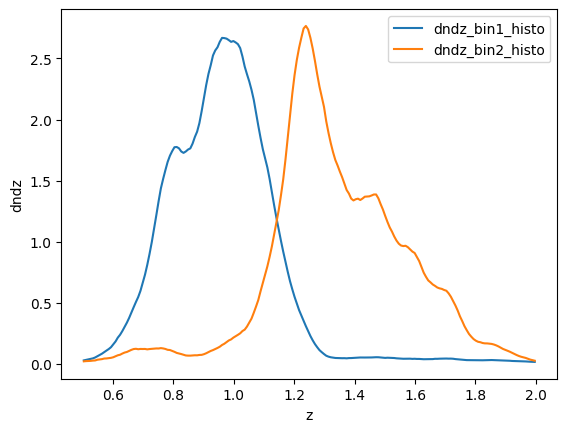

In [6]:
######## PLOT OF THE REDSHIFT DISTRIBUTIONS OF OBJECTS ########
plt.plot(z_bin1_histo, dndz_bin1_histo, label='dndz_bin1_histo')
plt.plot(z_bin2_histo, dndz_bin2_histo, label='dndz_bin2_histo')
plt.legend()
plt.xlabel('z')
plt.ylabel('dndz')
plt.show()

# Defining the functions for the comparissons

In [7]:
# Obs.: Problem with the "mass_function" in the nc_ccl.py file. I commented it there.
def compute_galaxy_galaxy_angular_cls(ells, Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu, z1, dndz1, z2=None, dndz2=None):
    """
    Compare the angular power spectrum of two galaxy type probes.

    Numcosmo apparently can't skip l's. It have just lmin and lmax as parameters in the angular power spectrum computation, in a continuous
    way.
    """
    ###################### TIME START ##########################
    start = time.time()
    
    ##### GENERAL #####
    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ##### COSMOLOGIES #####
    # Defining the CCL cosmology.
    ccl_cosmo = pyccl.Cosmology(
        Omega_c=Omega_c, 
        Omega_b=Omega_b, 
        Neff=Neff,
        m_nu=m_nu,
        h=h, 
        n_s=n_s,
        Omega_k=Omega_k, 
        Omega_g=None,
        w0=w0, 
        wa=wa, 
        sigma8=sigma8,
        transfer_function='eisenstein_hu',
        T_CMB = T_CMB,
        matter_power_spectrum='linear',
    )
    # Setting CCL to high precision.
    ccl_cosmo_set_high_prec()

    # Defining the NumCosmo cosmology.
    cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj(ccl_cosmo)
    # More info: https://github.com/NumCosmo/NumCosmo/blob/master/numcosmo_py/ccl/nc_ccl.py

    # Initialize tracers in CCL.
    trcs_ccl = dict()

    #### COMPUTING THE Cls #####
    if (z2 is None) and (dndz2 is None):
        print('Computing the auto angular power spectrum of one tracer.')
        ### Computing the angular power spectrum in CCL.
        unity_bias_1 = np.array([1 for i in np.arange(0, len(z1))])
        trcs_ccl['g1'] = pyccl.NumberCountsTracer(cosmo=ccl_cosmo, dndz=(z1, dndz1), bias=(z1, unity_bias_1), mag_bias=None, has_rsd=False)
        ccl_cl = pyccl.angular_cl(ccl_cosmo, trcs_ccl['g1'], trcs_ccl['g1'], ells)
        ccl_cl = np.array(ccl_cl)

        
        ### Computing the angular power spectrum in NumCosmo.
        # Defining Ncm vectors.
        v_z1  = Ncm.Vector.new_array (z1)
        v_pz1 = Ncm.Vector.new_array (dndz1)

        # Defining the splines.
        s_pz1 = Ncm.SplineCubicNotaknot.new_full (v_z1, v_pz1, True)

        # Defining the kernels.
        nc_g1 = None
        nc_g1 = Nc.XcorLimberKernelGal.new (z1[0], z1[-1], 1, 0.0, s_pz1, dist, False)

        # Pushing the objects to mset in NumCosmo.
        mset = Ncm.MSet.empty_new ()
        mset.set (cosmo)
        mset.push (nc_g1)

        # Setting the function to compute the angular power spectrum in NumCosmo.
        xcor = Nc.Xcor.new (dist, ps_lin, Nc.XcorLimberMethod.GSL)

        # Getting the size of the ells array.
        len_l = ells.size

        # Defining a Ncm vector for saving the cls.
        nc_cl = Ncm.Vector.new (len_l)

        # Preparing things.
        xcor.prepare (cosmo)
        nc_g1.prepare (cosmo)

        # Computing the angular power spectrum.
        xcor.limber (nc_g1, nc_g1, cosmo, ells[0], ells[-1], nc_cl)

        # Getting the results and converting them to Numpy arrays.
        nc_cl_values = [Ncm.Vector.get (nc_cl, i) for i in np.arange(0,len_l)]
        nc_cl = np.array(nc_cl_values)
    else:
        print('Computing the cross angular power spectrum of two tracers.')
        ### Computing the angular power spectrum in CCL.
        unity_bias_1 = np.array([1 for i in np.arange(0, len(z1))])
        unity_bias_2 = np.array([1 for i in np.arange(0, len(z2))])
        trcs_ccl['g1'] = pyccl.NumberCountsTracer(cosmo=ccl_cosmo, dndz=(z1, dndz1), bias=(z1, unity_bias_1), mag_bias=None, has_rsd=False)
        trcs_ccl['g2'] = pyccl.NumberCountsTracer(cosmo=ccl_cosmo, dndz=(z2, dndz2), bias=(z2, unity_bias_2), mag_bias=None, has_rsd=False)
        ccl_cl = pyccl.angular_cl(ccl_cosmo, trcs_ccl['g1'], trcs_ccl['g2'], ells)
        ccl_cl = np.array(ccl_cl)

        
        ### Computing the angular power spectrum in NumCosmo.
        # Defining Ncm vectors.
        v_z1  = Ncm.Vector.new_array (z1)
        v_z2  = Ncm.Vector.new_array (z2)
        v_pz1 = Ncm.Vector.new_array (dndz1)
        v_pz2 = Ncm.Vector.new_array (dndz2)

        # Defining the splines.
        s_pz1 = Ncm.SplineCubicNotaknot.new_full (v_z1, v_pz1, True)
        s_pz2 = Ncm.SplineCubicNotaknot.new_full (v_z2, v_pz2, True)

        # Defining the kernels.
        nc_g1 = None
        nc_g2 = None
        nc_g1 = Nc.XcorLimberKernelGal.new (z1[0], z1[-1], 1, 0.0, s_pz1, dist, False)
        nc_g2 = Nc.XcorLimberKernelGal.new (z2[0], z2[-1], 1, 0.0, s_pz2, dist, False)

        # Pushing the objects to mset in NumCosmo.
        mset = Ncm.MSet.empty_new ()
        mset.set (cosmo)
        mset.push (nc_g1)
        mset.push (nc_g2)

        # Setting the function to compute the angular power spectrum in NumCosmo.
        xcor = Nc.Xcor.new (dist, ps_lin, Nc.XcorLimberMethod.GSL)

        # Getting the size of the ells array.
        len_l = ells.size

        # Defining a Ncm vector for saving the cls.
        nc_cl = Ncm.Vector.new (len_l)

        # Preparing things.
        xcor.prepare (cosmo)
        nc_g1.prepare (cosmo)
        nc_g2.prepare (cosmo)

        # Computing the angular power spectrum.
        xcor.limber (nc_g1, nc_g2, cosmo, ells[0], ells[-1], nc_cl)

        # Getting the results and converting them to Numpy arrays.
        nc_cl_values = [Ncm.Vector.get (nc_cl, i) for i in np.arange(0,len_l)]
        nc_cl = np.array(nc_cl_values)

    ###################### TIME END ##########################
    end = time.time()
    print('Elapsed time: '+str(end - start)+'s')
    return ccl_cl, nc_cl



def compute_abs_relative_diff(array_ref, array_comp):
    relative_diff = np.abs((array_ref - array_comp)/array_ref)
    return relative_diff

def compute_accuracy_metric_cross(auto1_ref, auto2_ref, cross_ref, cross_comp, ells):
    ### ACCURACY METRIC ###
    # Source: page 28, https://arxiv.org/pdf/1812.05995.pdf
    Cab_comp = cross_comp
    
    ### The reference to compute sig_l
    Caa_ref = auto1_ref
    Cbb_ref = auto2_ref
    Cab_ref = cross_ref

    intern_fact = (Caa_ref*Cbb_ref + Cab_ref**2)/(2*ells+1)
    sig_l = np.sqrt(intern_fact)

    A_acc_cross = np.abs((Cab_comp - Cab_ref)/sig_l)

    return A_acc_cross

def compute_accuracy_metric_auto(auto_ref, auto_comp, ells):
    ## AUTO 1
    # For cross PS of fields a and b, we must have Caa, Cbb and Cab of the independent realization.
    # For auto PS of field a, Caa, Cbb and Cab can be set to the same value.

    Caa_comp = auto_comp
    
    ### The reference to compute sig_l
    Caa_ref = auto_ref
    
    intern_fact = (2*Caa_ref**2)/(2*ells+1)
    sig_l = np.sqrt(intern_fact)

    A_acc_auto = np.abs((Caa_comp - Caa_ref)/sig_l)

    return A_acc_auto

def compute_multiple_cosmologies_angular_cls(chosen_cosmologies, ells, z1, dndz1, z2=None, dndz2=None):
    CCL_cls = {}
    NC_cls = {}
    A_acc = {}
    ###### Running the loop
    for cosmology in chosen_cosmologies:    
        Omega_c = CCL_cosmologies[cosmology][0]
        Omega_b = CCL_cosmologies[cosmology][1]
        Omega_v = CCL_cosmologies[cosmology][2]
        h = CCL_cosmologies[cosmology][3]
        sigma8 = CCL_cosmologies[cosmology][4]
        n_s = CCL_cosmologies[cosmology][5]
        w0 = CCL_cosmologies[cosmology][6]
        wa = CCL_cosmologies[cosmology][7]
        Neff = CCL_cosmologies[cosmology][8]
        m_nu = CCL_cosmologies[cosmology][9]

        if z2 is None and dndz2 is None:
            calc_type = "AUTO"
        else:
            calc_type = "CROSS"
            
        print('Cosmology: '+str(cosmology))
        print('Type: '+str(calc_type))
        
        CCL_cls[cosmology], NC_cls[cosmology] = \
        compute_galaxy_galaxy_angular_cls(ells, Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu, z1, dndz1, z2, dndz2)

        A_acc[cosmology] = compute_accuracy_metric_auto(NC_cls[cosmology], CCL_cls[cosmology], ells)
    return CCL_cls, NC_cls, A_acc

# COMPARING THE INTERPOLATIONS METHODS

The way that the interpolation is done in NumCosmo is the following:

In [8]:
### Computing the angular power spectrum in NumCosmo.
# Defining Ncm vectors.
v_z1  = Ncm.Vector.new_array (z_bin1_histo_np)
v_pz1 = Ncm.Vector.new_array (dndz_bin1_histo_np)

# Defining the splines.
s_pz1 = Ncm.SplineCubicNotaknot.new_full (v_z1, v_pz1, True)

In [9]:
#dir(Ncm.Spline.eval)
minimum_z = min(z_bin1_histo)
maximum_z = max(z_bin1_histo)
step = 0.0001
z_array = np.arange(minimum_z,maximum_z, step)

Nc_Spline_values = np.array([Ncm.Spline.eval (s_pz1, i) for i in z_array])

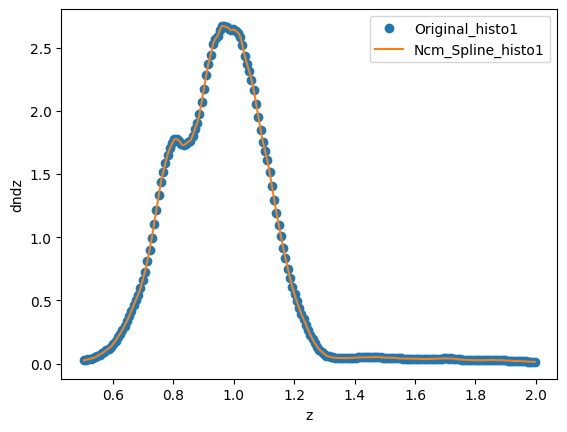

In [10]:
plt.plot(z_bin1_histo_np, dndz_bin1_histo_np, 'o', label='Original_histo1')
plt.plot(z_array, Nc_Spline_values, '-', label='Ncm_Spline_histo1')
plt.legend()
plt.xlabel('z')
plt.ylabel('dndz')
plt.show()

The way that the interpolation is done in CCL is the following:

In [11]:
### Use Interp1d
# https://ccl.readthedocs.io/en/latest/api/pyccl.tracers.html
# https://ccl.readthedocs.io/en/latest/_modules/pyccl/tracers.html#NumberCountsTracer
# https://github.com/LSSTDESC/CCL/blob/master/pyccl/tracers.py

CCL_Spline = interp1d(z_bin1_histo_np, dndz_bin1_histo_np, bounds_error=False, fill_value=0)
CCL_Spline_values = CCL_Spline(z_array)

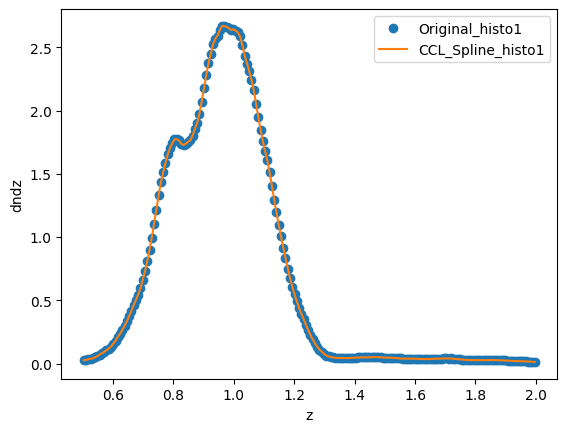

In [12]:
plt.plot(z_bin1_histo_np, dndz_bin1_histo_np, 'o', label='Original_histo1')
plt.plot(z_array, CCL_Spline_values, '-', label='CCL_Spline_histo1')
plt.legend()
plt.xlabel('z')
plt.ylabel('dndz')
plt.show()

Let us compare both.

In [13]:
relative_diff_spline = np.abs((CCL_Spline_values - Nc_Spline_values)/Nc_Spline_values)

[Text(0.5, 0, 'z'), Text(0, 0.5, 'Rel. Diff.')]

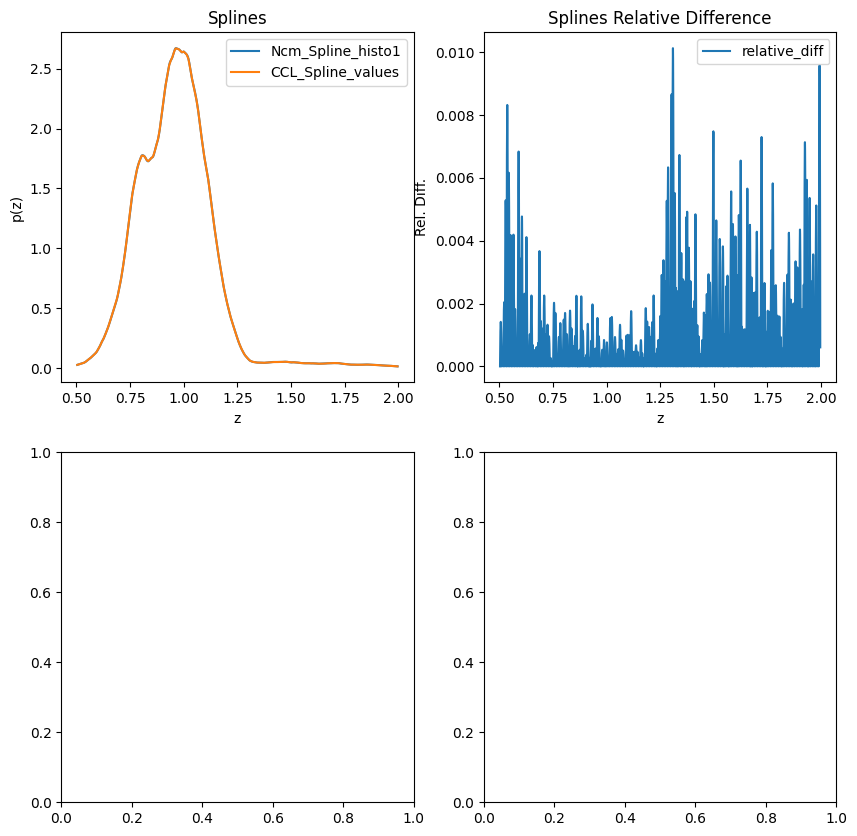

In [14]:
col_num = 2
size_ref = 5
line_num = 2

fig, axs = plt.subplots(line_num, col_num, figsize=(col_num*size_ref,line_num*size_ref))

i=0
j=0
axs[i, j].plot(z_array, Nc_Spline_values, label="Ncm_Spline_histo1")
axs[i, j].plot(z_array, CCL_Spline_values, label="CCL_Spline_values")
axs[i, j].set_title("Splines")
axs[i, j].legend()
axs[i, j].set(xlabel='z', ylabel='p(z)')

i=0
j=1
axs[i, j].plot(z_array, relative_diff_spline, label="relative_diff")
axs[i, j].set_title("Splines Relative Difference")
axs[i, j].legend()
axs[i, j].set(xlabel='z', ylabel='Rel. Diff.')